
# Feature Redundancy

Motivation filtering correlated features:
* Permutation importance of correlated features may be overestimated. (Strobl, C., Boulesteix, A. L., Kneib, T., Augustin, T., & Zeileis, A. (2008). Conditional variable importance for random forests. BMC bioinformatics, 9(1), 307.). Note that permutation importance should be used for feature selection with care (like many other feature importance measures). For example, if several features are correlated, and the estimator uses them all equally, permutation importance can be low for all of these features: dropping one of the features may not affect the result, as estimator still has an access to the same information from other features. So if features are dropped based on importance threshold, such correlated features could be dropped all at the same time, regardless of their usefulness. 
* ReliefF is sensitive to correlated features.

In [35]:
import numpy as np
import pandas as pd

from dgufs.dgufs import DGUFS

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
data_sq = pd.read_csv('./../../../data_source/to_analysis/sqroot_concat.csv', index_col=0)
data_log = pd.read_csv('./../../../data_source/to_analysis/gauss05_concat.csv', index_col=0)
data_sq.shape, data_log.shape

((198, 607), (198, 610))

In [39]:
X = pd.concat((data_sq, data_log), axis=1)


corr_matrix = X.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_sub = X.drop(to_drop, axis=1,)
print(X.shape), print(X_sub.shape)

(198, 1217)
(198, 303)


(None, None)

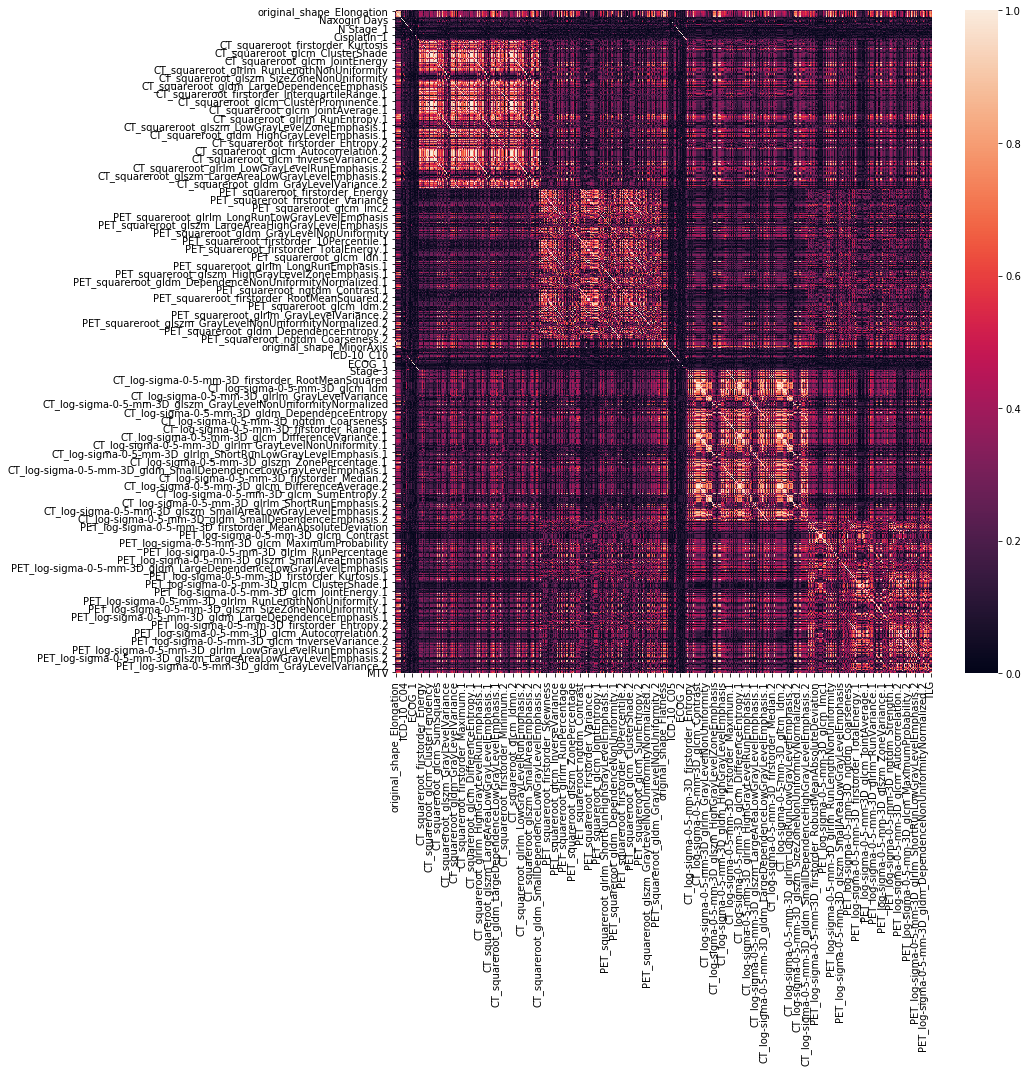

In [11]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    X.corr().abs()
)
plt.tight_layout()

For n_clusters = 2 The average silhouette_score is : 0.2139714886142589
For n_clusters = 3 The average silhouette_score is : 0.09301918043507593
For n_clusters = 4 The average silhouette_score is : 0.08462527710934727
For n_clusters = 5 The average silhouette_score is : 0.05557767513210421
For n_clusters = 6 The average silhouette_score is : 0.05141762085474902
For n_clusters = 8 The average silhouette_score is : 0.03529564482447853


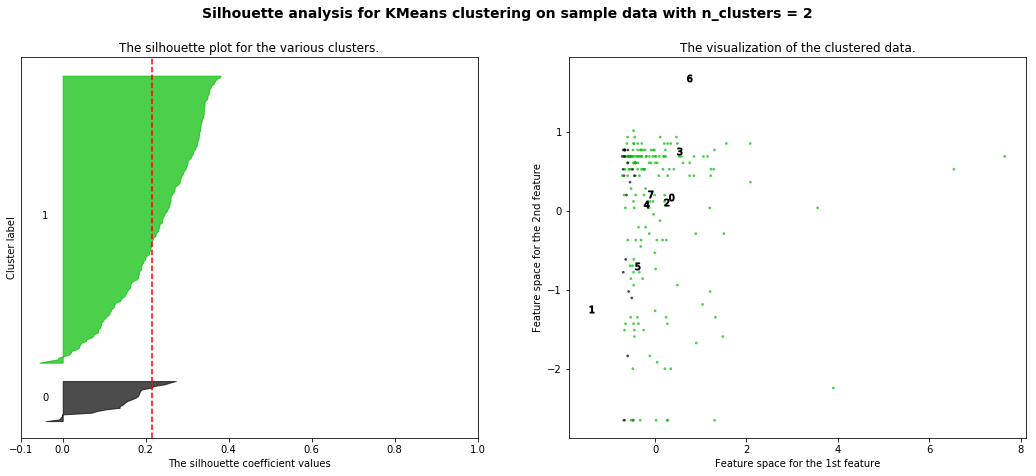

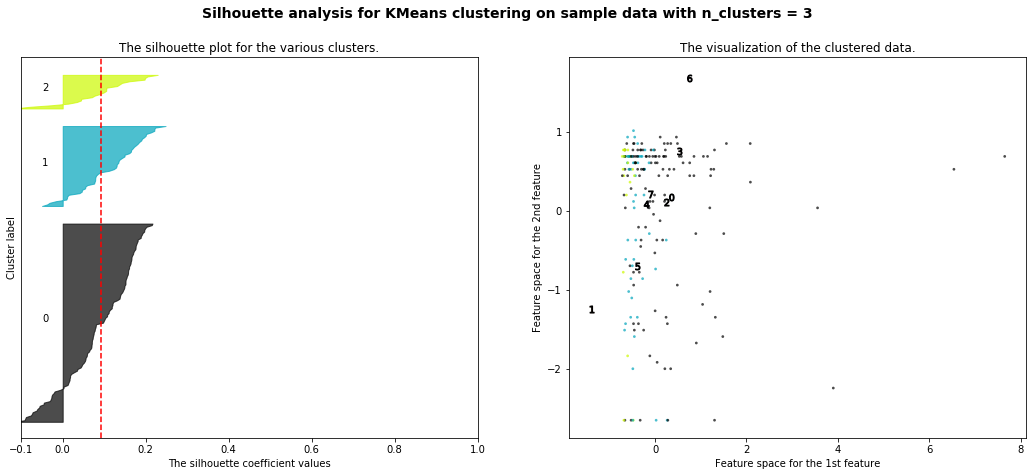

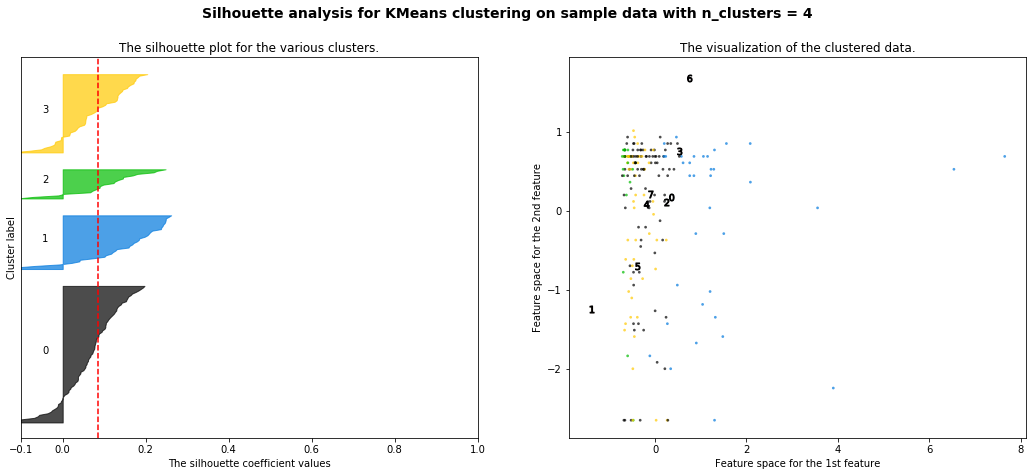

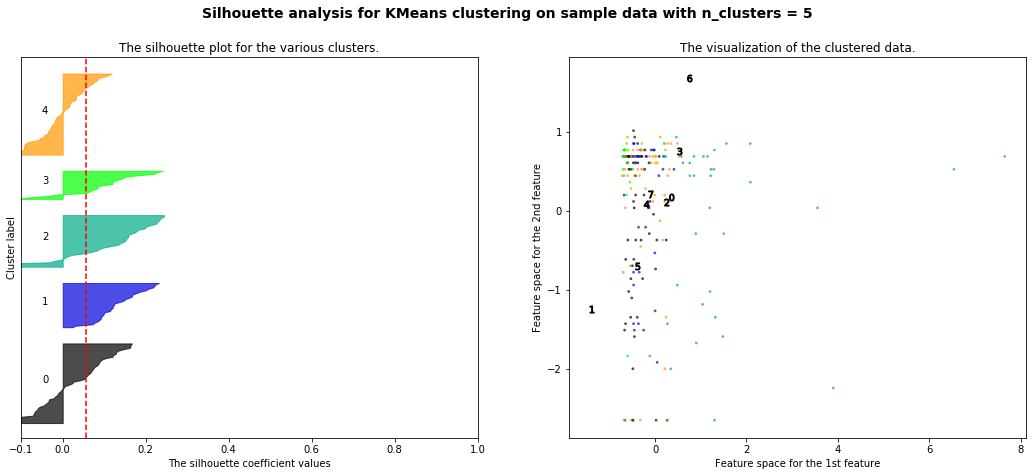

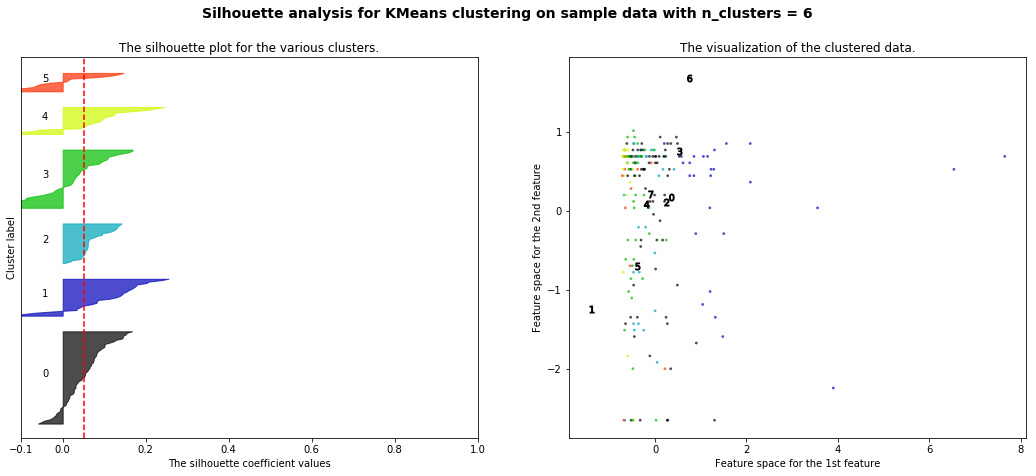

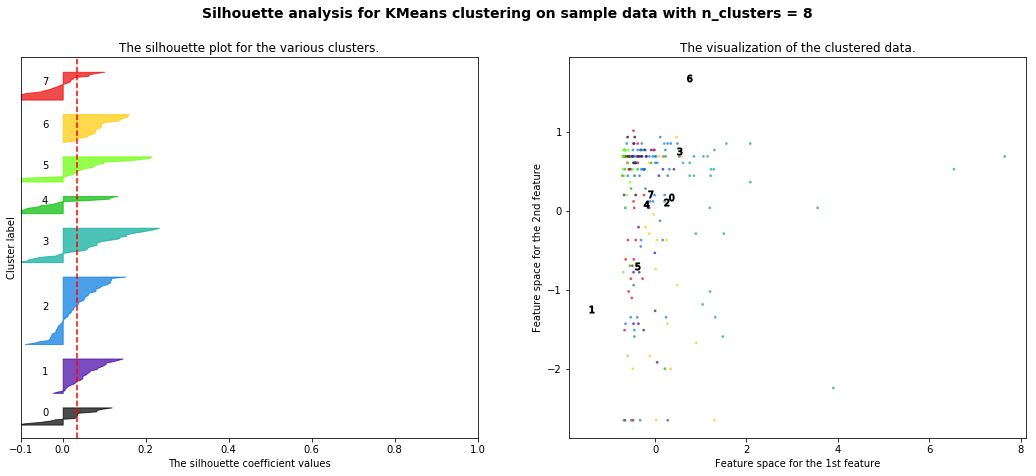

In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score


import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 8]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
        
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    rater = DGUFS(num_clusters=n_clusters, num_features=90)
    rater.fit(X_std)
    
    _X_sub = X_std[:, rater.support]
    
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer = cluster.SpectralClustering(
        n_clusters=n_clusters, eigen_solver='arpack',
        affinity="nearest_neighbors"
    )
    cluster_labels = clusterer.fit_predict(_X_sub)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(_X_sub[:, 0], _X_sub[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    


In [44]:
from sklearn.decomposition import PCA

[0.25375037 0.36087972 0.45995304 0.52654707 0.58712582 0.63056222
 0.66703547 0.69307579 0.71475991 0.73203054 0.74760884 0.7627402
 0.77598521 0.78757221 0.79841413 0.80869524 0.81759898 0.8260828
 0.83359297 0.84079996 0.84727671 0.85343093 0.85938154 0.86476802
 0.86986114 0.87476847 0.87929332 0.88370078 0.88790567 0.89199256]


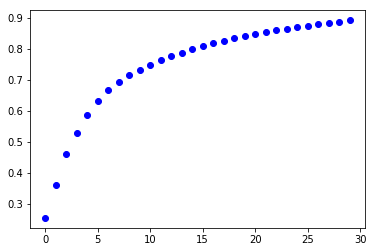

In [71]:
pca_model = PCA(n_components=30)
pca_model.fit(X_std)
print(np.cumsum(pca_model.explained_variance_ratio_))

plt.figure()
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), 'bo')

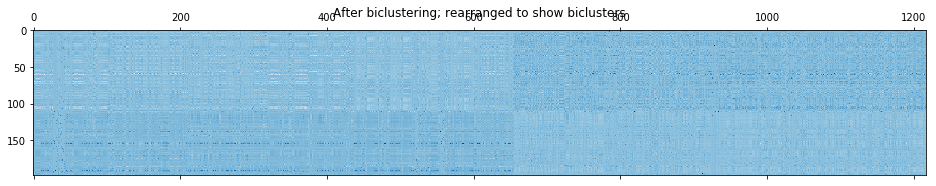

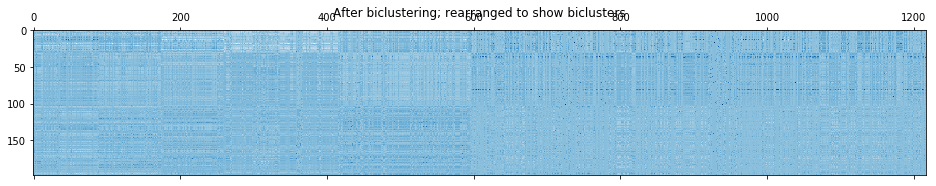

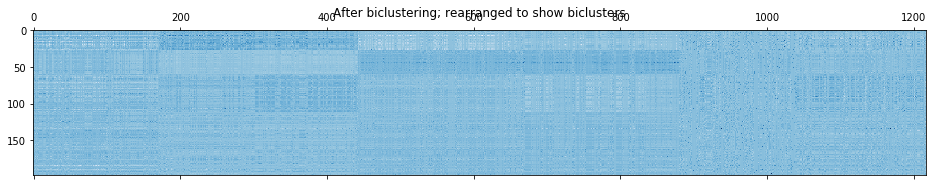

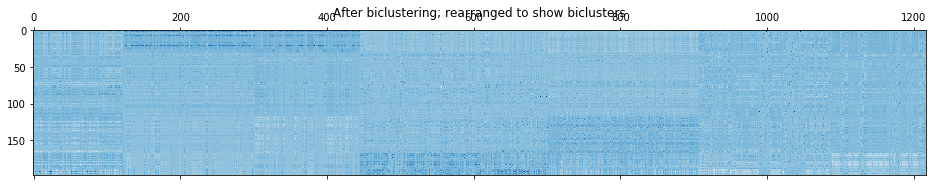

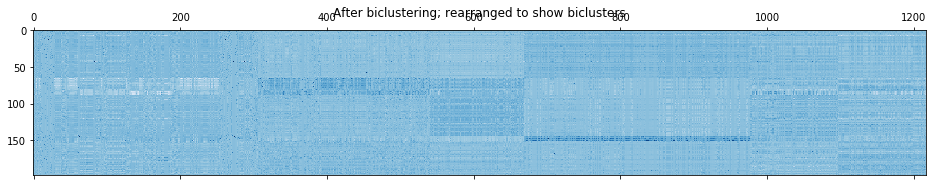

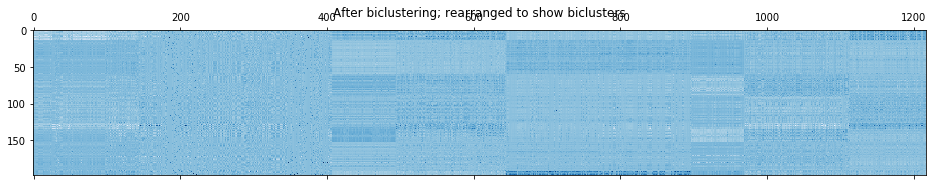

In [87]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score


import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 8]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

for n_clusters in range_n_clusters:
    
    model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                                 random_state=0)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    rater = DGUFS(num_clusters=n_clusters, num_features=90)
    rater.fit(X_std)
    
    _X_sub = X_std#[:, rater.support]
    
    
    model.fit(_X_sub)

    fit_data = _X_sub[np.argsort(model.row_labels_)]
    fit_data = fit_data[:, np.argsort(model.column_labels_)]

    plt.matshow(fit_data, cmap=plt.cm.Blues)
    plt.title("After biclustering; rearranged to show biclusters")

    #sns.heatmap(np.outer(np.sort(model.row_labels_) + 1,
    #                     np.sort(model.column_labels_) + 1),
    #            cmap=plt.cm.Blues)
    #plt.title("Checkerboard structure of rearranged data")